In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from keras.callbacks import ModelCheckpoint

2023-02-26 22:02:43.602126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
A = -0.8
B = 0.16
C = 0.1

dt = 1e-4

# u = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100, [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
u = 1
x = 0

y_arr = []

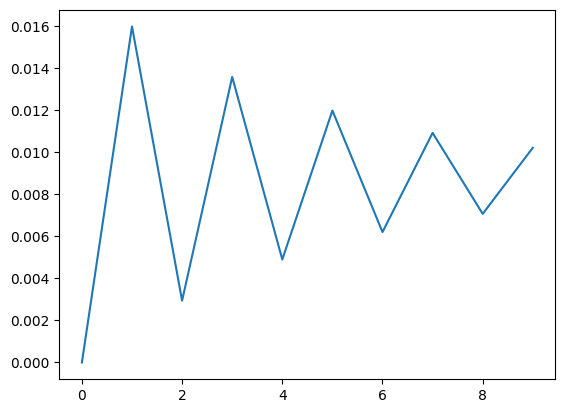

In [3]:
for t in range(10):
    y = C * x

    u = 1 - y

    x = A * x + B * u

    y_arr.append(y)

plt.plot(y_arr)
plt.show()

In [4]:
k_p = 0.12
k_i = 0.06
k_d = 0.007

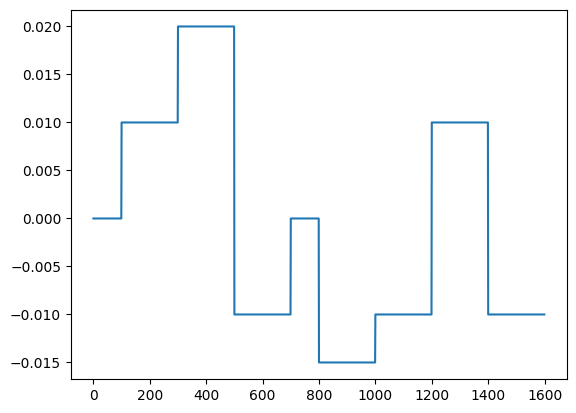

In [5]:
z_ref = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100 + [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
z_ref = np.array(z_ref).reshape(1600,)
plt.plot(z_ref)

In [6]:
e_int = 0
e_past = 0
z_t_arr = []

u = np.zeros((u.shape[0]),)
x = 0

for i in range(z_ref.shape[0]):
    z_t = C * x

    e = z_ref[i] - z_t
    e_diff = e - e_past

    u[i] = e * k_p + e_int * k_i + e_diff * k_d
    x = A * x + B * u[i]

    e_int += e
    e_past = e

    z_t_arr.append(z_t)

z_t_arr = np.array(z_t_arr)
print(z_t_arr.shape)
plt.plot(z_t_arr)
plt.plot(z_ref)
plt.show()

AttributeError: 'float' object has no attribute 'shape'

### Reinforcement Learning

In [2]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [3]:
#Dimension of State Space
num_states = 3
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = 0.2
lower_bound = -0.2

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  0.2
Min Value of Action ->  -0.2


In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(256, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    outputs = layers.Dense(1, activation="selu")(out)

    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    outputs = layers.Dense(1, activation="selu")(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
std_dev = 0.1
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(1000, 32)

2023-02-26 22:02:52.312010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# loss function
def loss(z_ref, z_t):
    return np.power(z_ref - z_t, 2)

# reward function
def GetReward(z_ref, z_t):
    loss_value = loss(z_ref, z_t)
    r = -np.log(loss_value) - np.power(loss_value, 2) #* np.exp(loss_value)
    return r

# generate z_ref command
def z_ref_generate():
    coeff = []
    values = []
    amount = np.random.randint(1, 3)

    for i in range(amount):
        coeff.append(np.random.randint(100,200))
        values.append(np.random.uniform(-0.02,0.02))

    coeff = np.array(coeff)
    values = np.array(values)

    z_ref = []
    for i in range(amount):
        z_ref += [values[i]]*coeff[i]

    return z_ref

# x function
def x_calculate(x, u, A, B):
    return A * x + B * u

# transition function from S state to S' state
def transition(x, u, C):
    z_t = C * x
    return z_t

In [10]:
def policy(state, noise_object):
    # error = loss(target_state, state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [11]:
# actor_model.load_weights("../weights/nn_actor.h5")
# critic_model.load_weights("../weights/nn_critic.h5")

# target_actor.load_weights("../weights/nn_target_actor.h5")
# target_critic.load_weights("../weights/nn_target_critic.h5")

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
# Define matrixes
A = 0.8
B = 0.9
C = 1
# Define start value x
x = 0
u = 0

total_episodes = 50
for ep in range(total_episodes):

    prev_state = u
    episodic_reward = 0

    z_ref = z_ref_generate()
    z_ref = np.array(z_ref)
    z_arr = []

    for step in range(z_ref.shape[0]):
    # while percent(z_ref[step], state)
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        prev_state = z_ref[step]

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        # z_ref = tf.expand_dims(tf.convert_to_tensor(), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        x = x_calculate(x, float(action[0]), A, B)
        state = transition(x, float(action[0]), C)
        # state = float(action[0])
        reward = GetReward(z_ref[step], state)
        z_arr.append(state)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        prev_state = state

    ep_reward_list.append(episodic_reward)
    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward),
        "z_ref = {} and z_arr = {}".format(np.sum(z_ref), np.sum(np.array(z_arr))))
    avg_reward_list.append(avg_reward)

    if ep % 10 == 0:
        fig, ax = plt.subplots(figsize=(4, 4))
        # ax.axis('equal')
        title = "{} {}".format("Episode Number", ep+1)

        ax.plot(z_ref, color = 'darkorange', label = 'Z_ref')
        ax.plot(z_arr, color = 'royalblue', label = 'Z_t')

        ax.legend(loc = 'upper left')
        plt.title(title)
        plt.show()

ValueError: Exception encountered when calling layer "model" "                 f"(type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (1,)

Call arguments received by layer "model" "                 f"(type Functional):
  • inputs=tf.Tensor(shape=(1,), dtype=float64)
  • training=False
  • mask=None

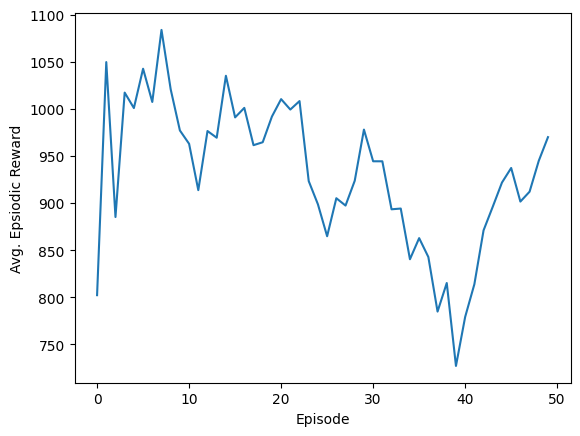

In [11]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [107]:
# Save the weights
actor_model.save_weights("../weights/nn_actor.h5")
critic_model.save_weights("../weights/nn_critic.h5")

target_actor.save_weights("../weights/nn_target_actor.h5")
target_critic.save_weights("../weights/nn_target_critic.h5")

### Supervised Learning